## Eradiate setup for simulation in spherical geometry

In [2]:
import eradiate
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from eradiate import scenes as ertsc
from eradiate import unit_registry as ureg

eradiate.set_mode("mono_polarized")
eradiate.plot.set_style()  # set plot style for eradiate


### Definition of a standard atmosphere

Specify standard atmosphere (e.g. tropical, midlatitude summer, midlatitude winter, subarctic summer, subarctic winter, US standard atmosphere 1976).

List all available identifiers with ```joseki.identifiers()```.

In [3]:
usstd=ertsc.atmosphere.MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
)

atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
            molecular_atmosphere=usstd,
            #particle_layers=[particle_layer]
    )

### Define an AtmosphereExperiment

All is put together in a eradiate "experiment". In addition the surface (here Lambertian) and the sun position need to be inlcuded.

In [4]:
def run_exp(spp, geometry, atmosphere, origins, directions, wavelength, sza, saa, integrator=None):
    """
    Run radiance simulation.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()
    
    exp = eradiate.experiments.AtmosphereExperiment( 
        geometry=geometry,
        surface={
            "type": "lambertian",
            "reflectance": 0.0,
        },
        illumination={
            "type": "directional",
            "zenith": sza,
            "azimuth": saa,
            "irradiance": 1.0
        },
        
        atmosphere=atmosphere,
        
        measures=[
            ertsc.measure.MultiRadiancemeterMeasure(
                id="radiances",
                origins=origins,
                directions=directions,
                srf={"type": "multi_delta", "wavelengths": wavelength}
            )],
        integrator=integrator
    )

    exp.integrator.stokes = True
    exp.integrator.meridian_align = True

    return eradiate.run(exp, spp=spp)

Define the wavelength, the viewing geometry and the sun position. We choose a solar zenith angle of 60° which is not extreme and realistic for polar orbiting satellites. 

In [ ]:
wavelength = np.array([400]) * ureg.nm

vza = np.arange(0.,88.1, 2.)
vaa = [0., 90., 180.] 
sza=60.
saa=0.

spp=1000000

layout = eradiate.scenes.measure.GridLayout(
        zeniths=180.-vza, azimuths=vaa,
    )


### Run the simulations

For spherical shell geometry the origin of the model coordinate system is at the center of the Earth, therefore the z-component of the location of the sensor (given in variable origins) is set to the sum of Earth radius and height of the atmosphere. 

In plane parallel geometry the z-componet of the location of the sensor corresponds to the height of the atmosphere.

In order to avoid numerical problems we include a small offset of 10cm. 

In [6]:
EARTH_RADIUS = eradiate.constants.EARTH_RADIUS

origins = np.zeros_like(layout.directions)-0.1
origins[:,2] += EARTH_RADIUS.m_as("m")+120000 # for spherical shell geometry the origin of the model coordinate system is at the center of the Earth

result_eradiate_sp = run_exp(spp=spp, geometry="spherical_shell", atmosphere=atmosphere, origins=origins, directions=layout.directions, wavelength=wavelength, sza=sza, saa=saa)


origins = np.zeros_like(layout.directions)-0.1
origins[:,2] += 120000
result_eradiate_pp = run_exp(spp=spp, geometry="plane_parallel", atmosphere=atmosphere, origins=origins, directions=layout.directions, wavelength=wavelength, sza=sza, saa=saa)

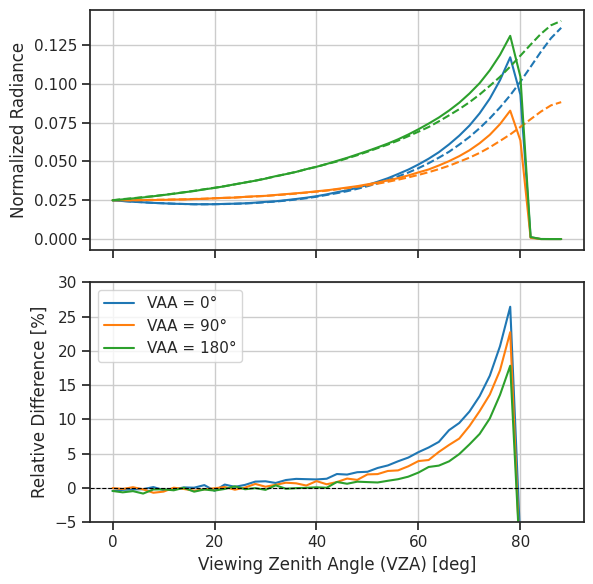

In [10]:
n_vza = len(vza)
n_vaa = len(vaa)

# Get the radiance for stokes 'I' (intensity)
radiance_sp = result_eradiate_sp.radiance.sel(stokes='I', sza=sza, saa=saa, w=400.0).isel(y_index=0)
radiance_sp_reshaped = radiance_sp.values.reshape(n_vaa, n_vza)

radiance_pp = result_eradiate_pp.radiance.sel(stokes='I', sza=sza, saa=saa, w=400.0).isel(y_index=0)
radiance_pp_reshaped = radiance_pp.values.reshape(n_vaa, n_vza)

fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

colors = ['tab:blue', 'tab:orange', 'tab:green']
vaa_labels = ['VAA = 0°', 'VAA = 90°', 'VAA = 180°']

# Upper plot: radiance vs vza
for i, (color, label) in enumerate(zip(colors, vaa_labels)):
    axs[0].plot(vza, radiance_sp_reshaped[i], color=color, label=f'Spherical ({label})', linestyle='-')
    axs[0].plot(vza, radiance_pp_reshaped[i], color=color, label=f'Plane-parallel ({label})', linestyle='--')

axs[0].set_ylabel('Normalized Radiance')
#axs[0].legend()
axs[0].grid()

# Lower plot: relative difference in percent
for i, (color, label) in enumerate(zip(colors, vaa_labels)):
    rel_diff_percent = 100 * (radiance_sp_reshaped[i] - radiance_pp_reshaped[i]) / radiance_pp_reshaped[i]
    axs[1].plot(vza, rel_diff_percent, color=color, label=label)

axs[1].set_xlabel('Viewing Zenith Angle (VZA) [deg]')
axs[1].set_ylabel('Relative Difference [%]')
axs[1].legend()
axs[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[1].set_ylim(-5, 30)
axs[1].grid()

plt.tight_layout()
plt.savefig("spherical_vs_plane_parallel.pdf")
plt.show()